In [1]:
from TTVFit.ttvfit import *
from TTVFit.lightcurve import *
from TTVFit.getdata import *

In [2]:
indir = 'wasp-107b/'
target_star = 'WASP-107'
target = 'WASP-107b'
period = 5.72148926
IDs = ['1185o8','1280o1','1201o8','1224o3','1185o9']
tess_path = 'TESS Timing data/WASP/WASP-107 b/tess_pytransit.txt'

In [3]:
savePlots = True
saveData = True
GD = GetData(target,indir,period,IDs,saveData)
LC = LightCurve(target,indir,period,nbin=100,savePlots=savePlots)

In [4]:
time = GD.getTime()
time

,Median,+1 sigma,-1 sigma,Path,epoch,ID
0,2.459959e+06,0.000017,0.000017,wasp-107b/1/S5_emcee_fitparams_ch0.csv,0,1185o8
1,2.459964e+06,0.000011,0.000011,wasp-107b/2/S5_emcee_fitparams_ch0.csv,1,1280o1
2,2.460108e+06,0.000009,0.000009,wasp-107b/3/posteriors.dat,26,1201o8
3,2.460119e+06,0.000015,0.000015,wasp-107b/4/S5_emcee_fitparams_ch0.csv,28,1224o3
4,2.460130e+06,0.000019,0.000019,wasp-107b/5/S5_emcee_fitparams_ch0.csv,30,1185o9


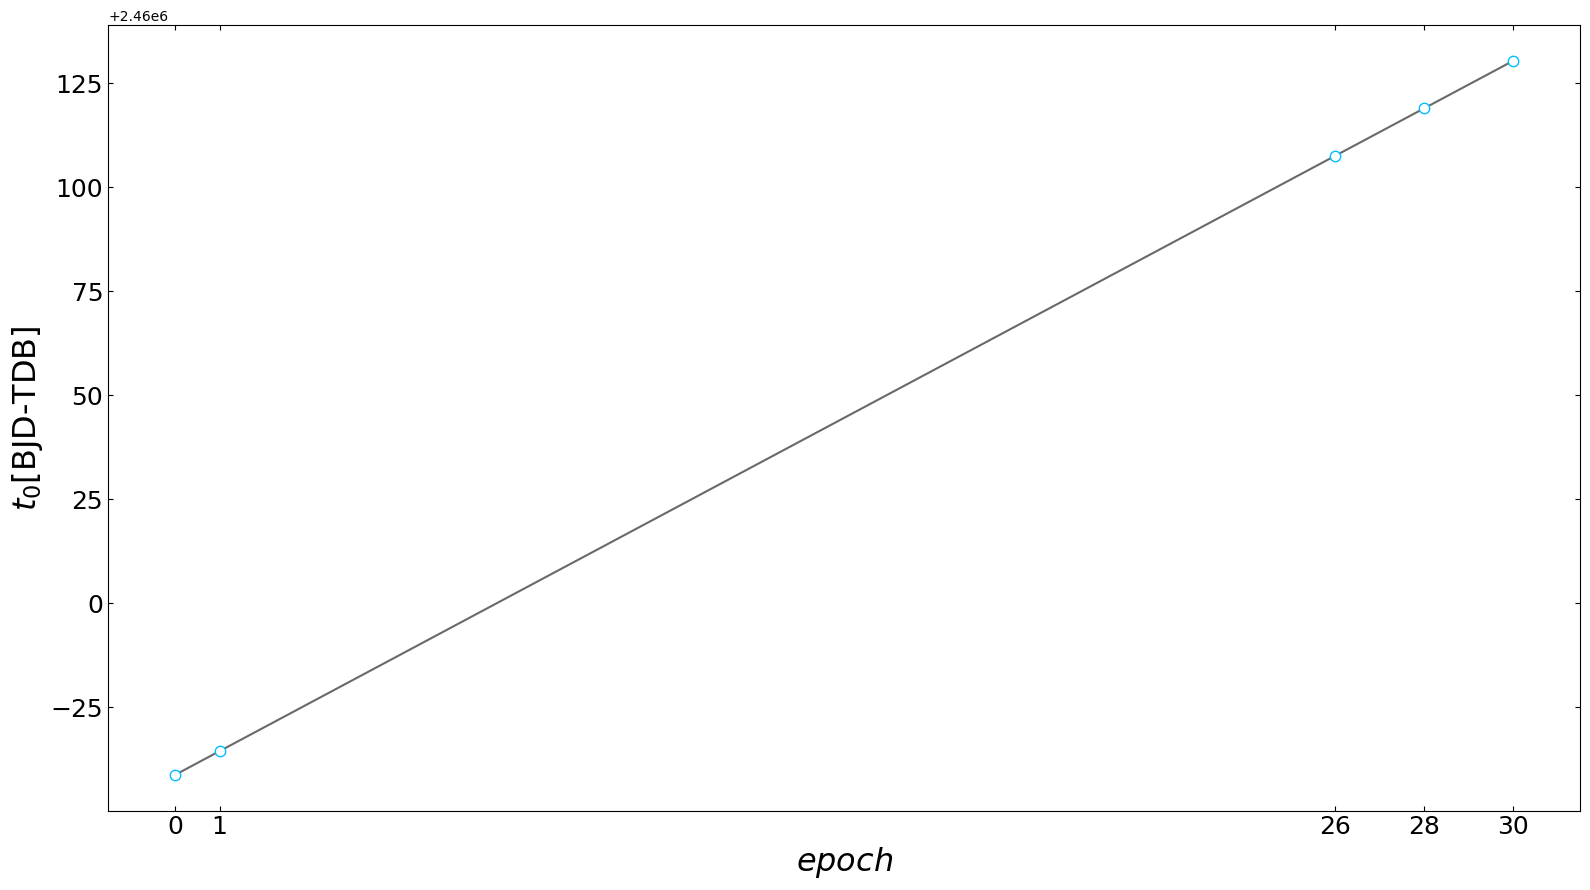

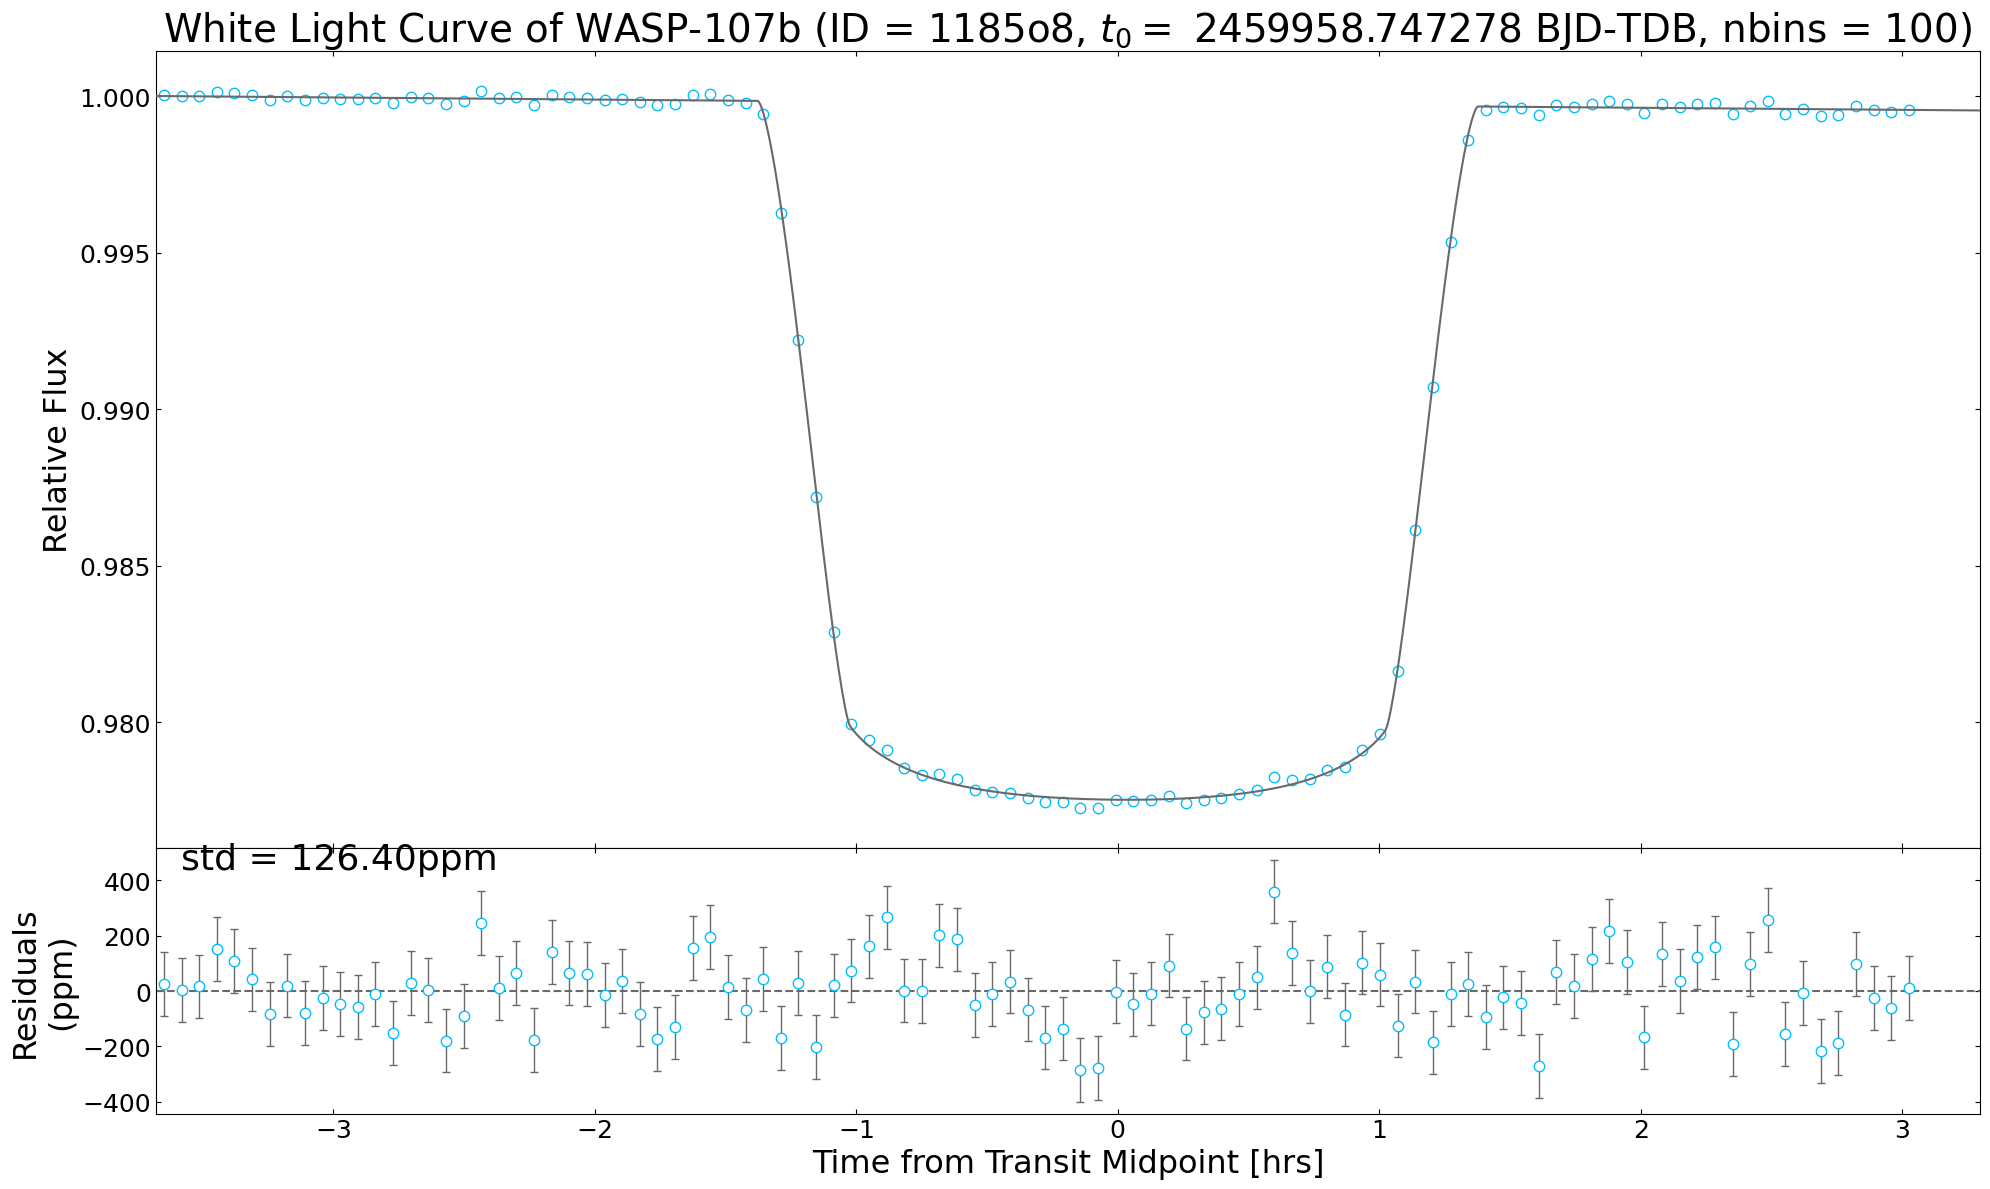

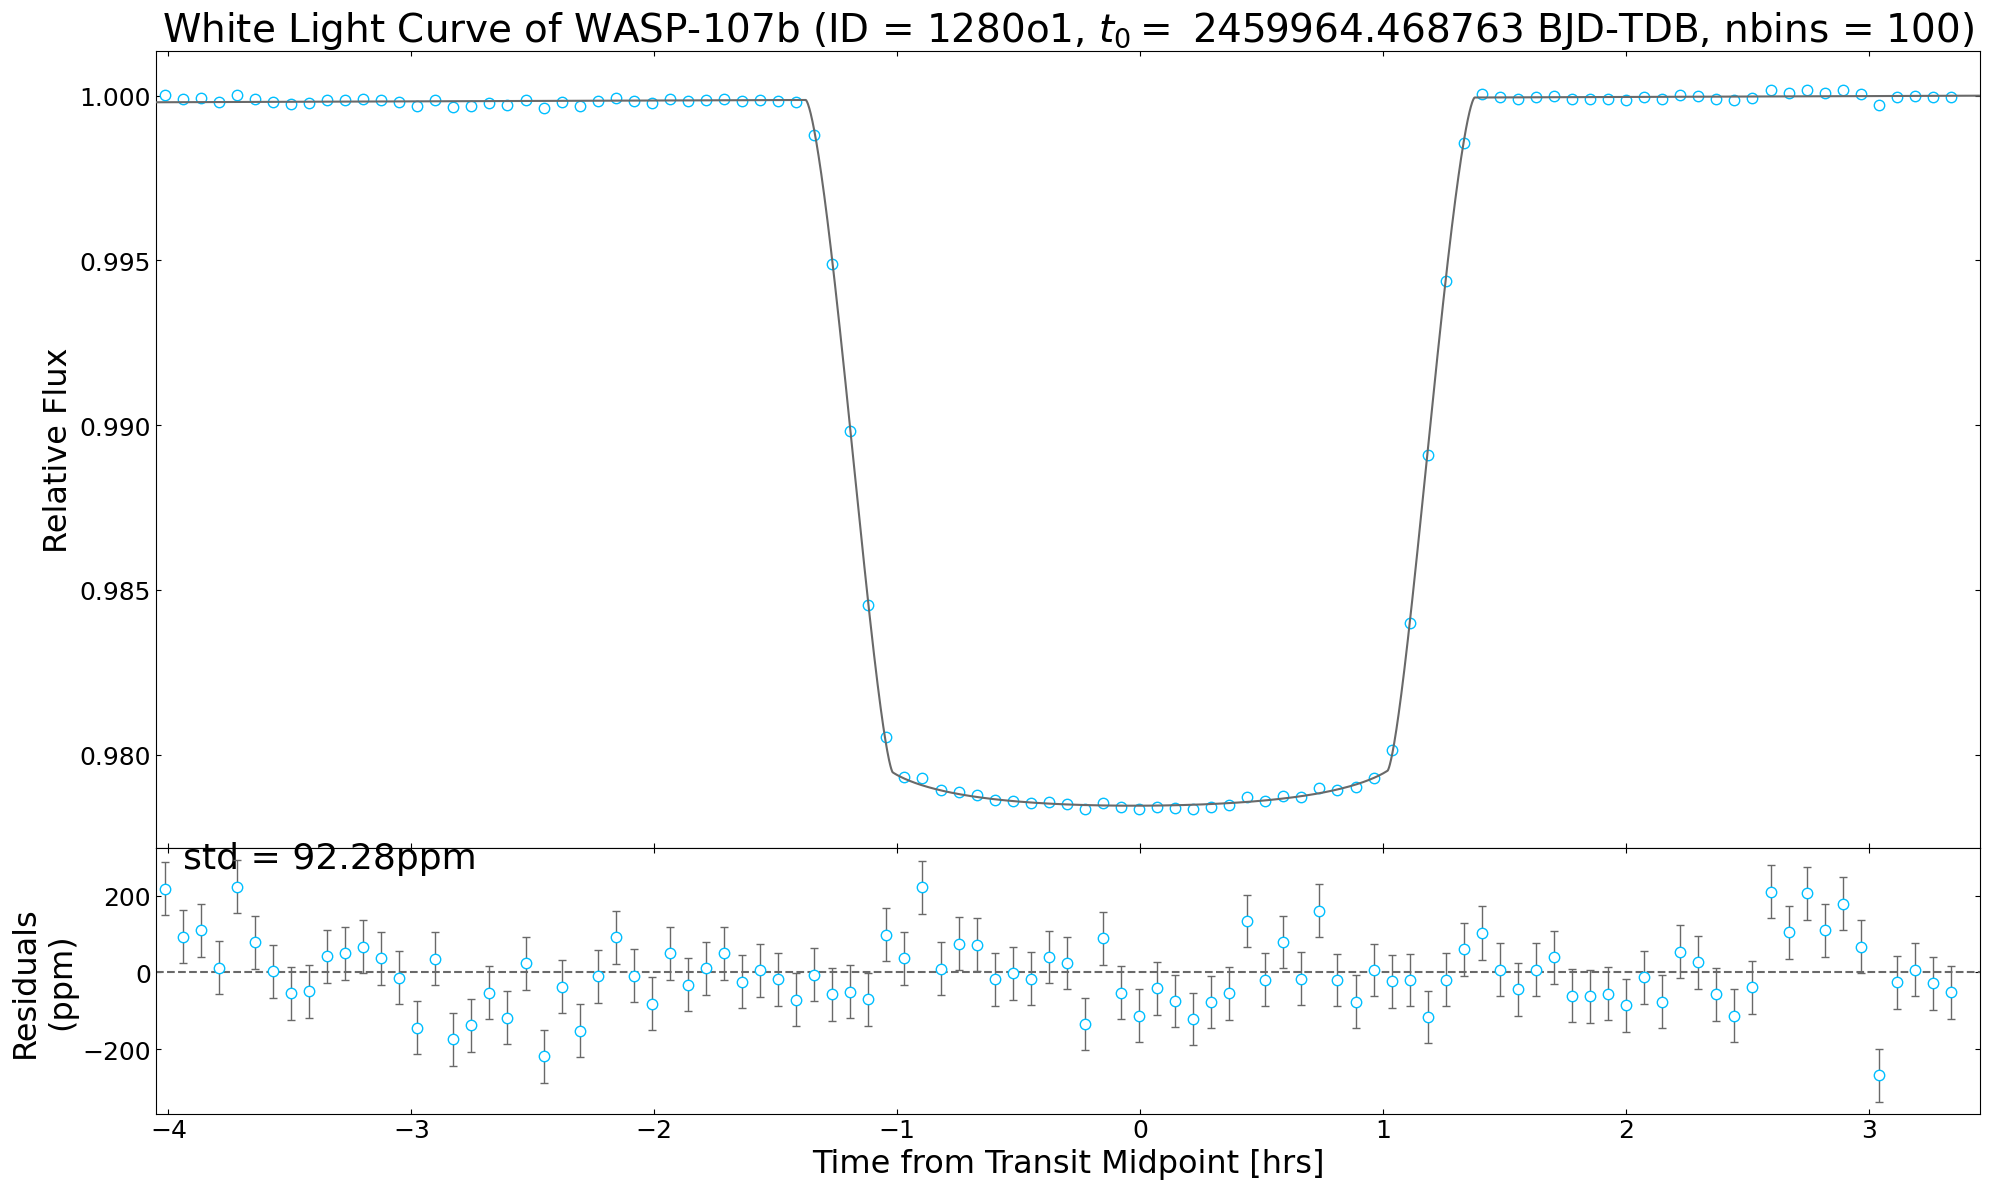

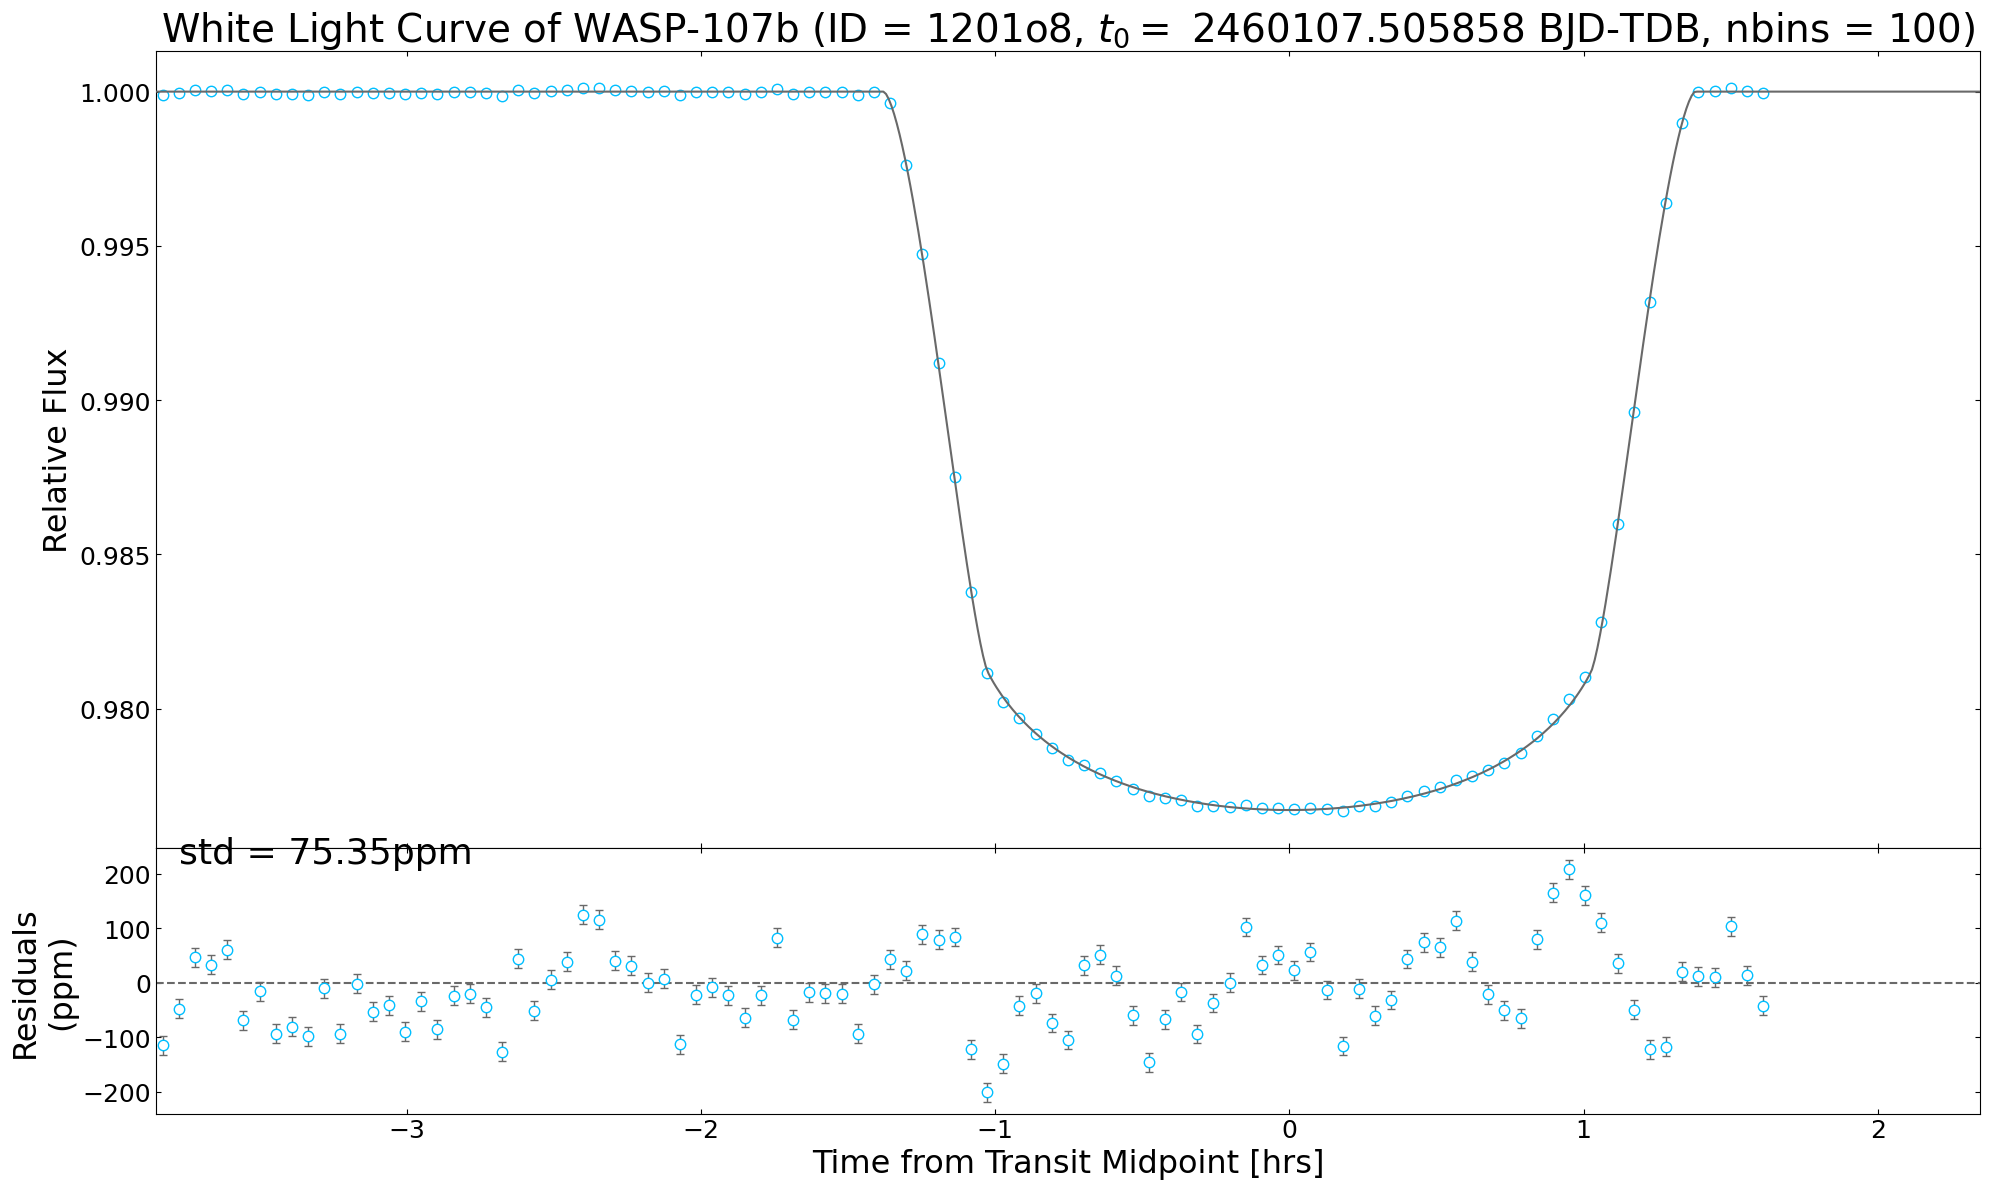

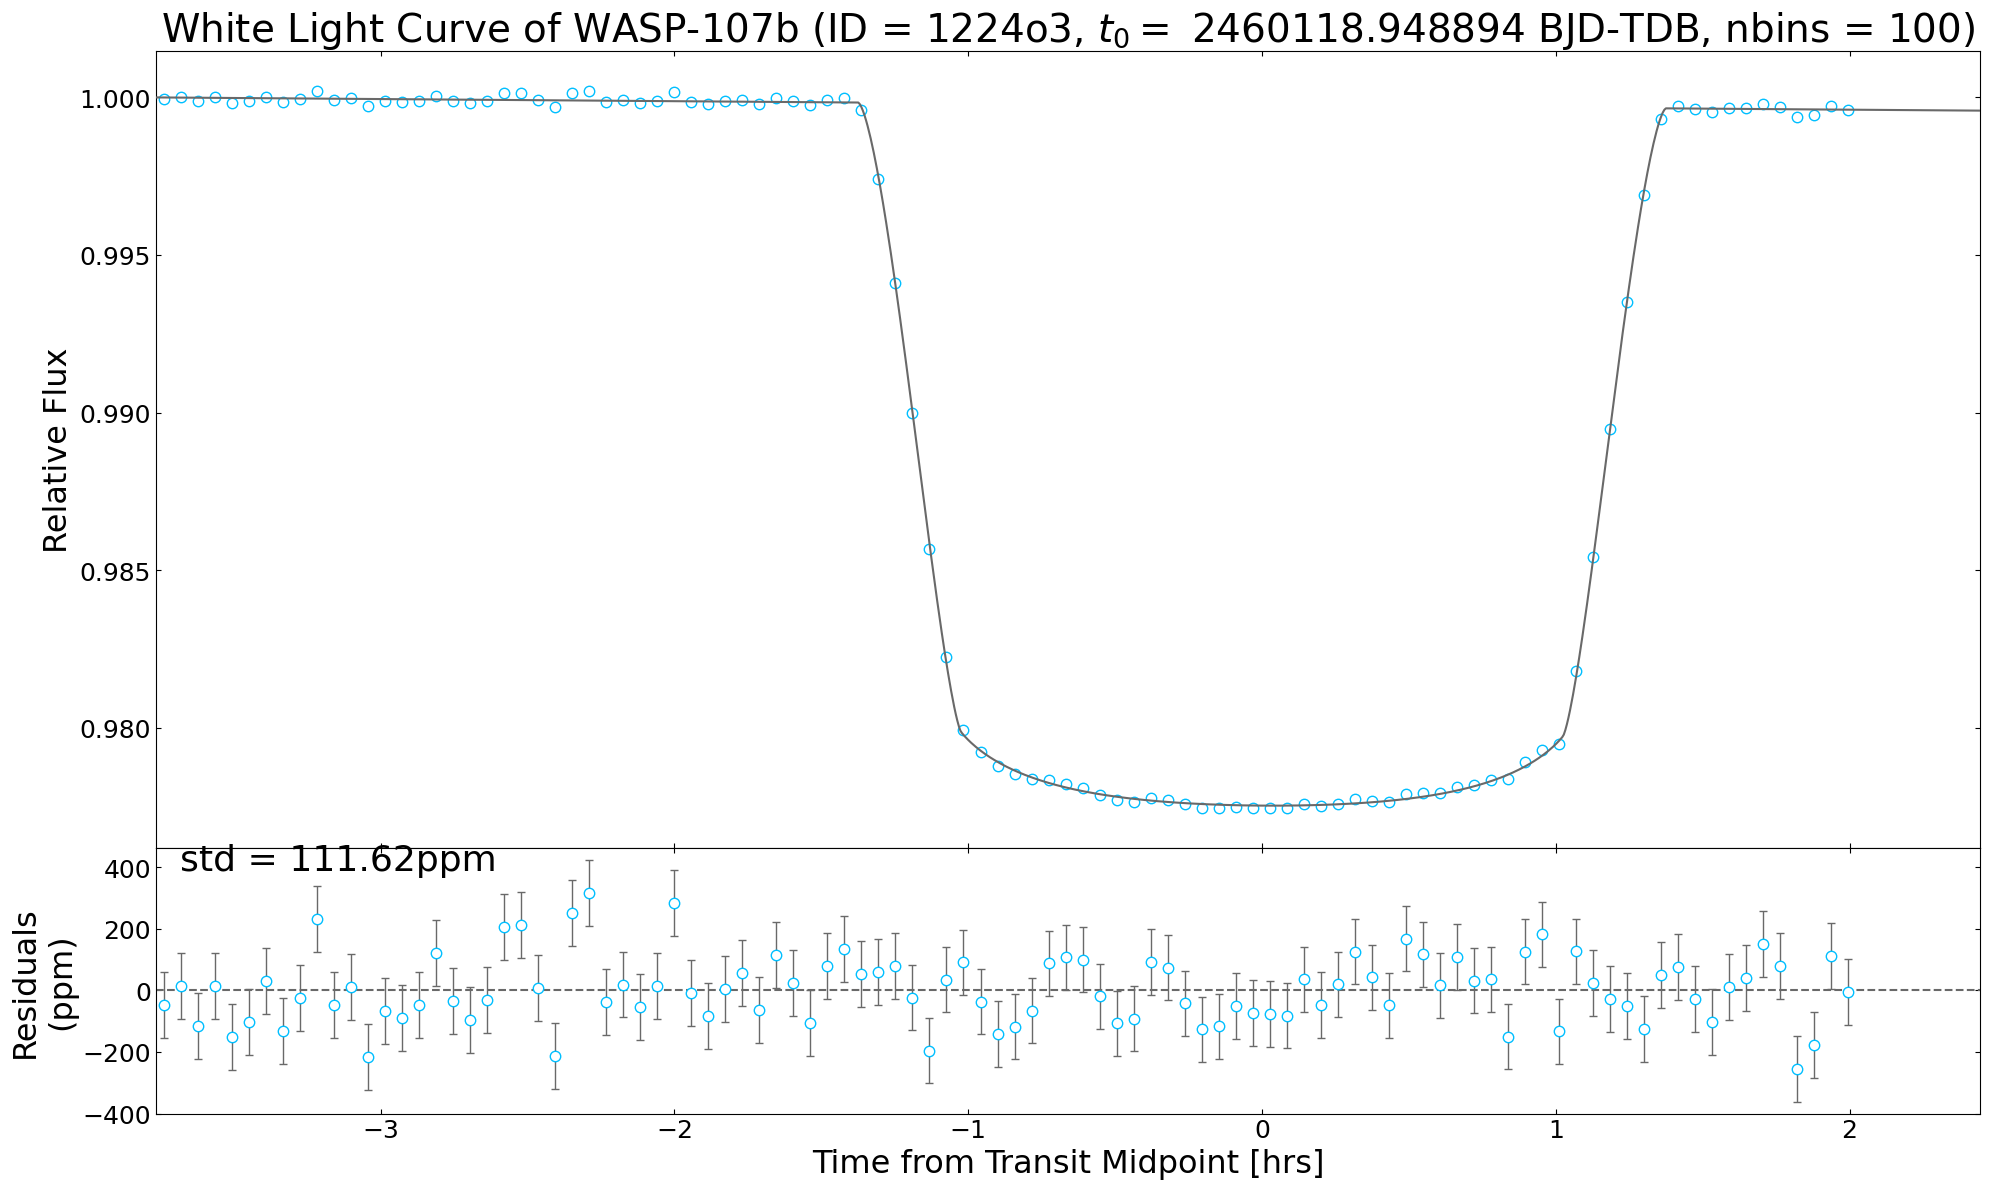

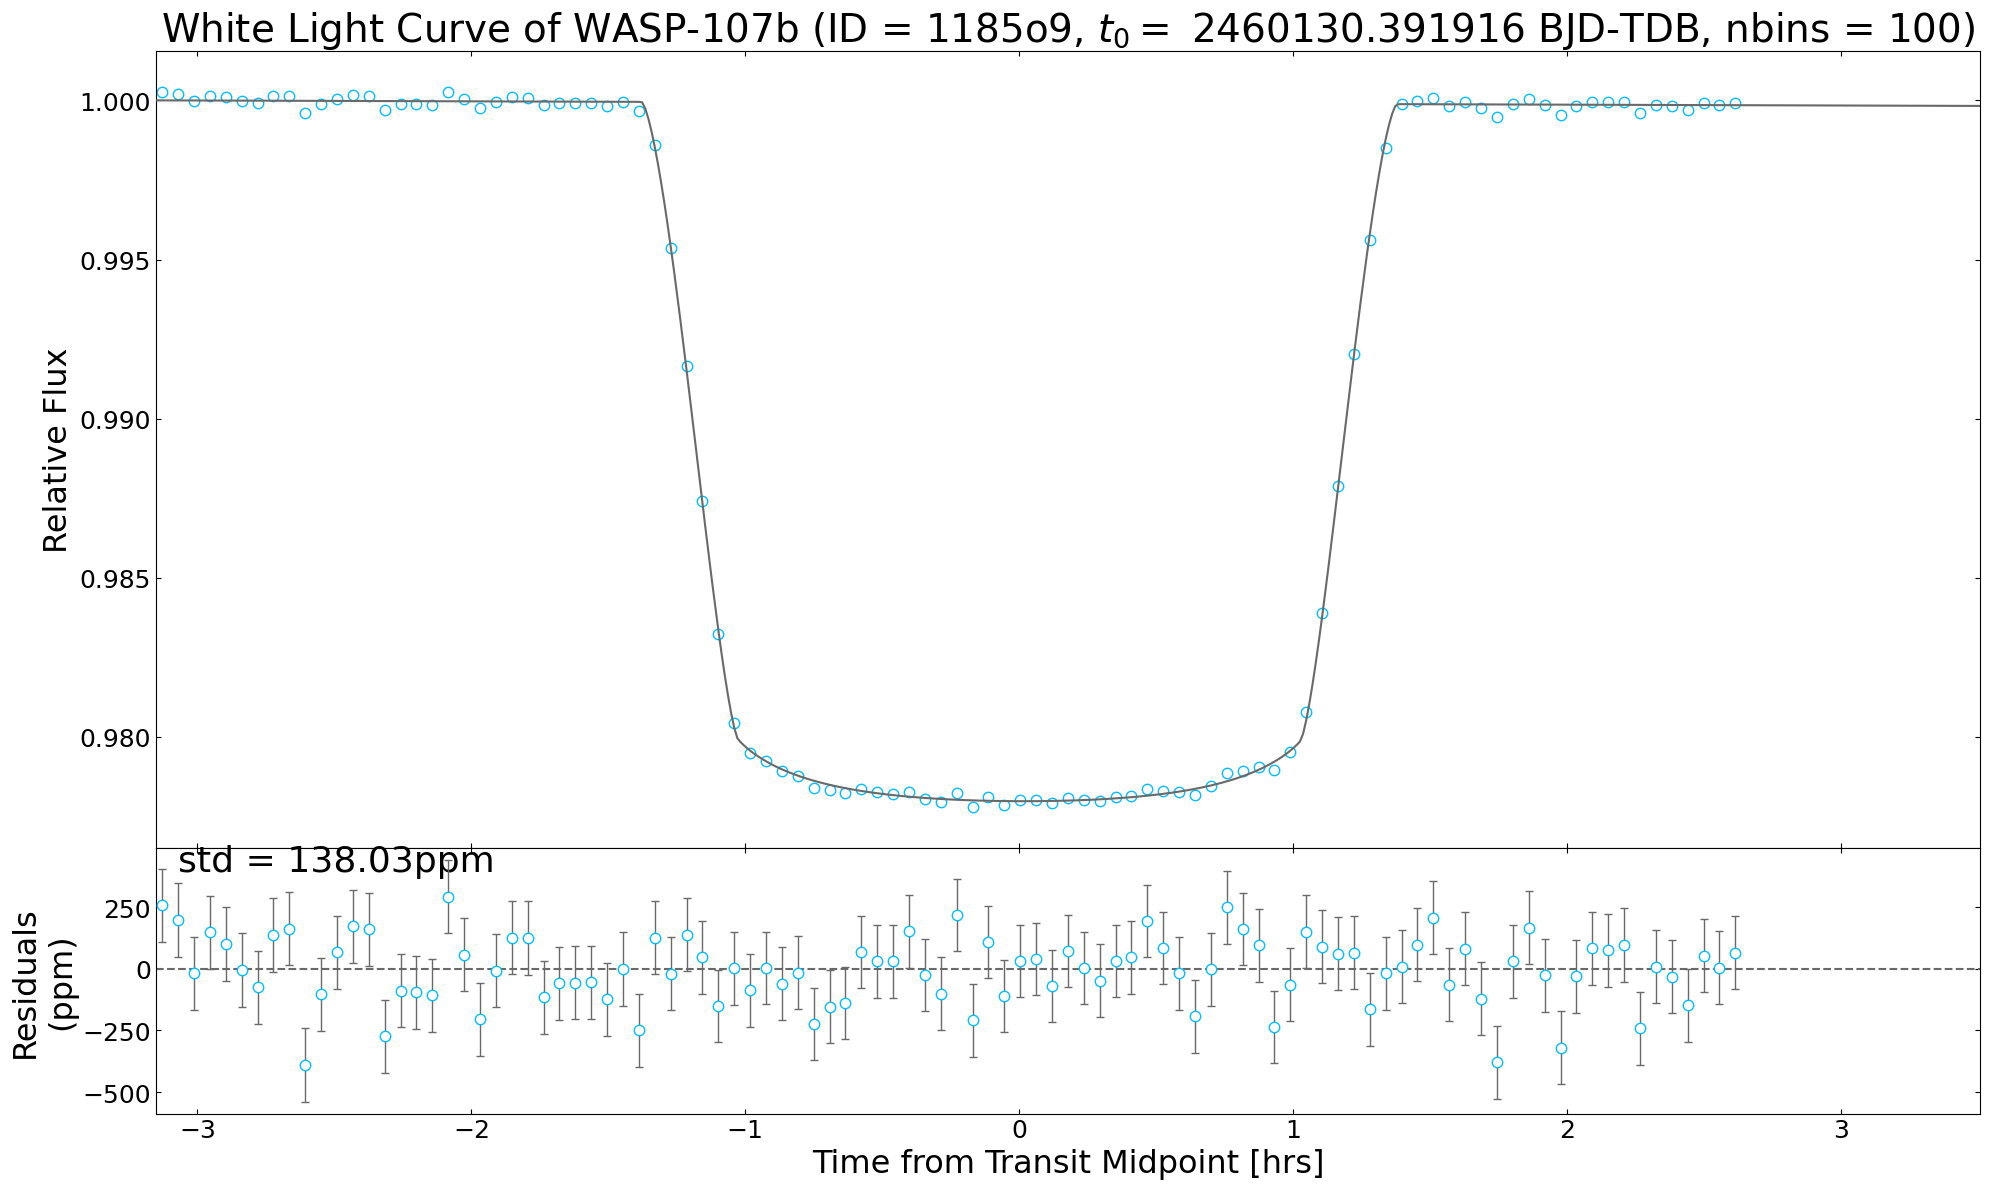

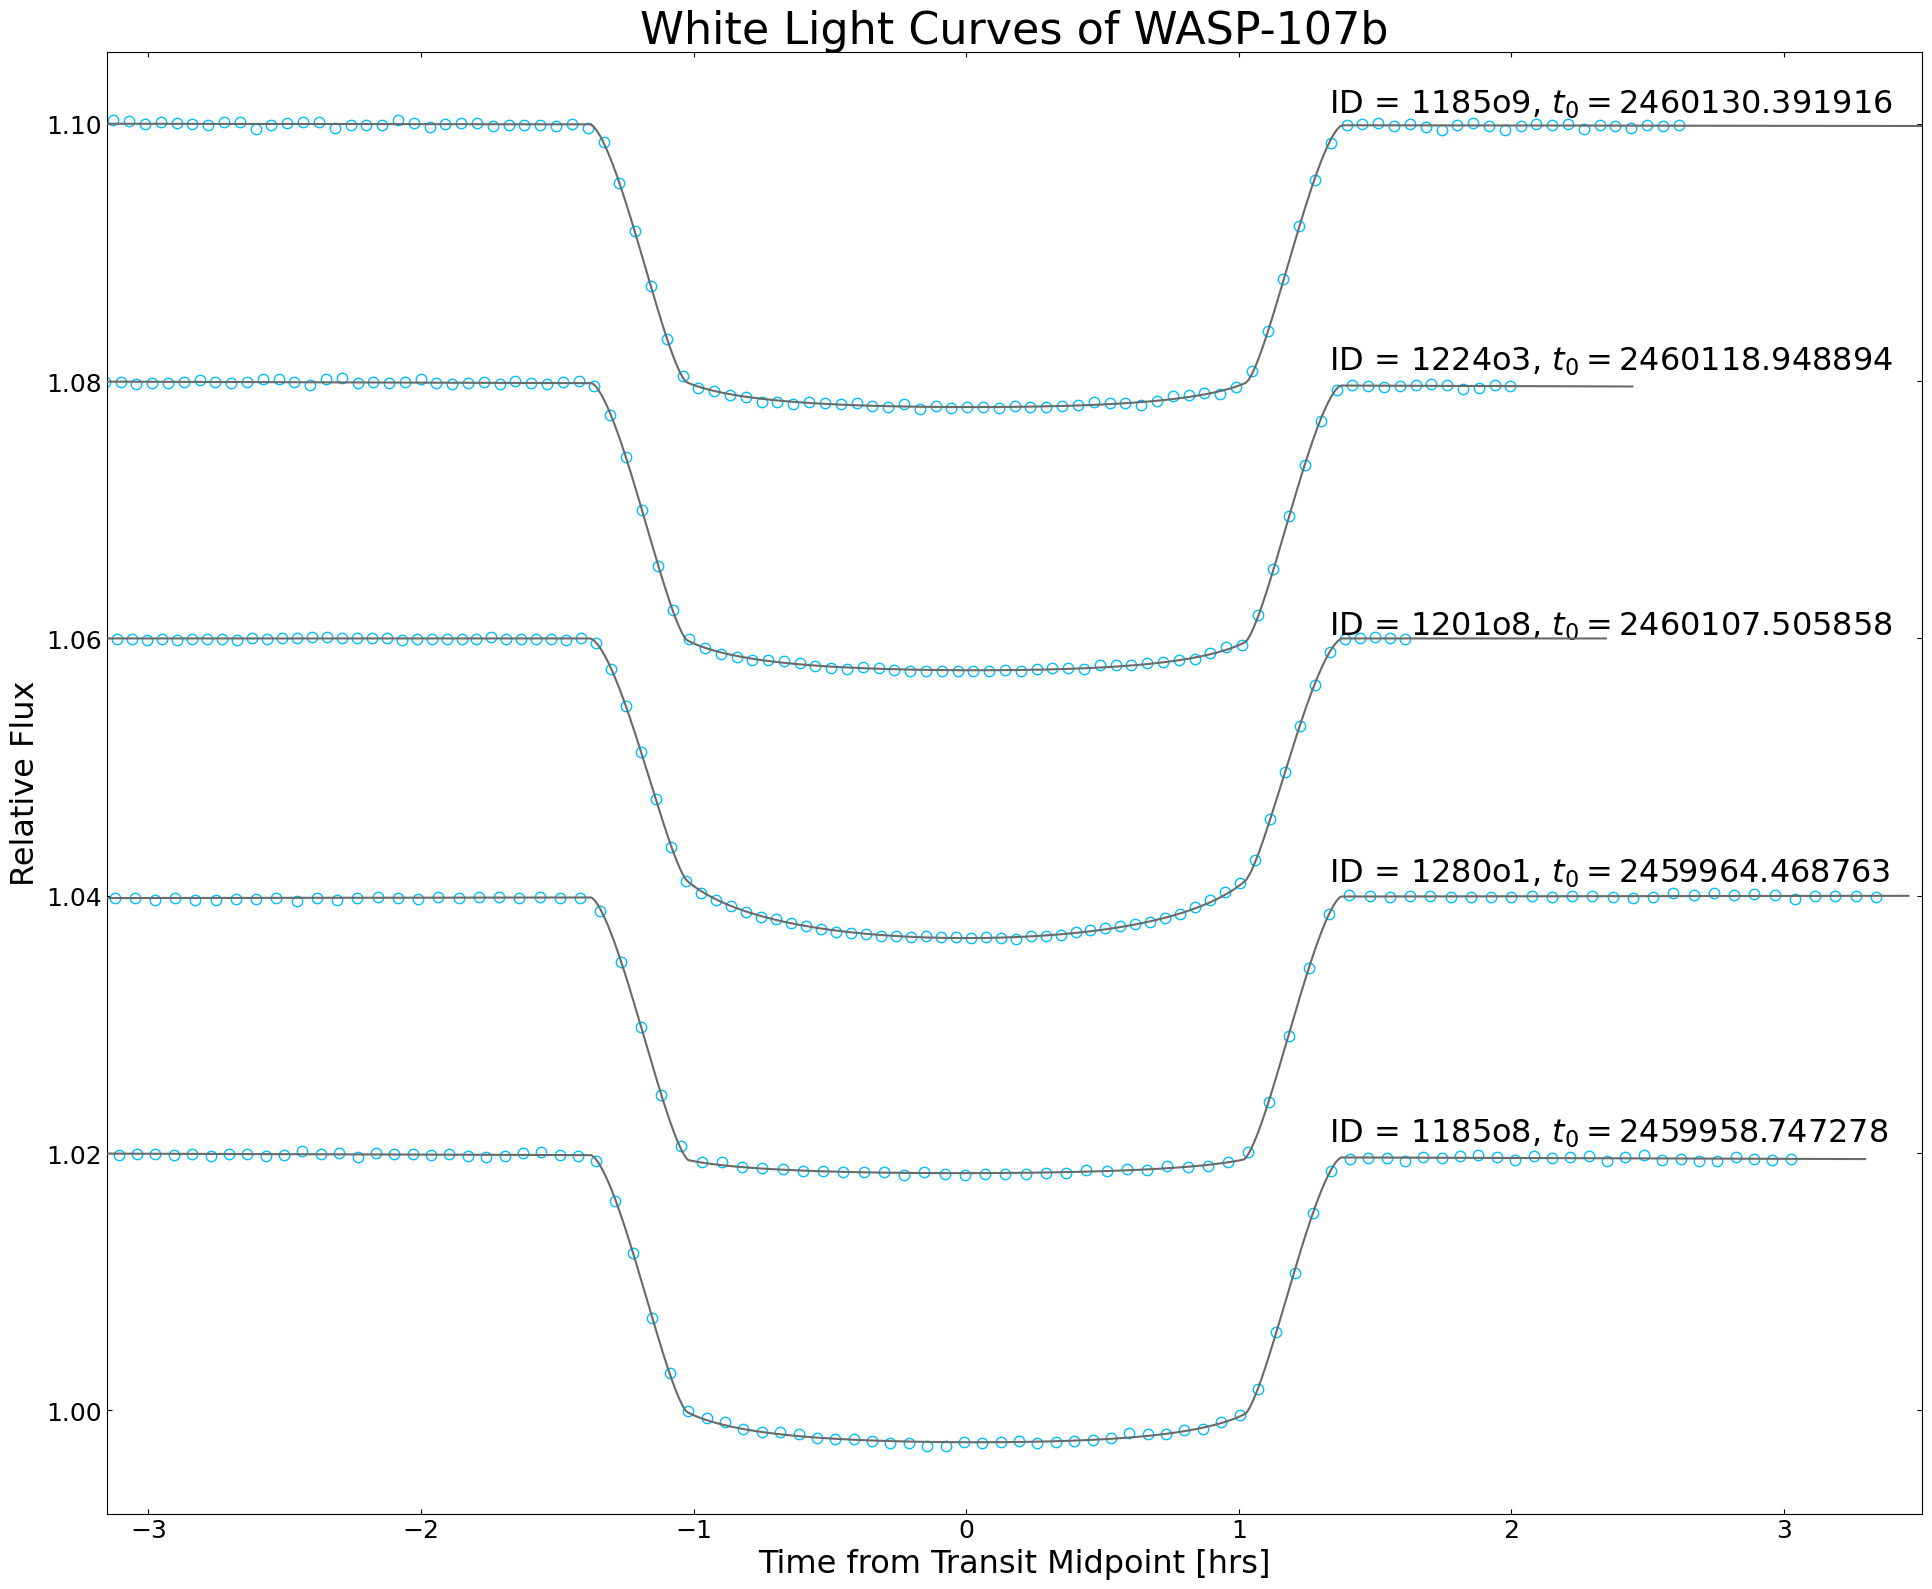

In [5]:
LC.plotTransits(time)
t0s, datas, ids = LC.plotAllClightCurves(time)
LC.plotLightCurveTogether(t0s,datas,ids)

In [6]:
t = GD.getT('HST.xlsx','tess.csv',tess_path,target_star)
t.loc[0,'Label'] = 'Ground'
t.loc[1,'Label'] = 'K2'
t.to_csv(indir+'t.csv', index=False)
t.to_latex(indir+'t.tex', index=False, float_format="%.7f")
t

,T_mid,Uncertainty,Label,Reference,Epoch
0,2.456514e+06,0.000100,Ground,2017A&A...604A.110A,0
1,2.457584e+06,0.000011,K2,2017MNRAS.469.1622M,187
2,2.457905e+06,0.000047,HST-Ma,Ma et al. 2024,243
3,2.457910e+06,0.000046,HST-Ma,Ma et al. 2024,244
4,2.458580e+06,0.000429,TESS-I&W,Ivshina & Winn 2022,361
5,2.458591e+06,0.000355,TESS-I&W,Ivshina & Winn 2022,363
6,2.459959e+06,0.000017,JWST,This Work,602
7,2.459964e+06,0.000011,JWST,This Work,603
8,2.460108e+06,0.000009,JWST,This Work,628
9,2.460119e+06,0.000015,JWST,This Work,630


In [7]:
t_re = GD.checkDuplicates(t)
t_re

No duplicate.


In [8]:
RE = True
if t_re is None:
    RE = False
if RE:
    data = t_re.copy()
else:
    data = t.copy()

In [9]:
times0 = data['T_mid'][0]
a = 0.005
times0_est = [times0 - a, times0 + a,'U']
b = 0.0001
period_est = [period-b, period+b,'U']

sampler_parameters = {
    'emcee':{
        'nwalkers':32,
        'nsteps':100000,
        'nburnin':15000,
    }
}

kind = 'Linear'
rej_sigma = 5
multiprocessing = True
sampler = 'emcee'
parameters = [times0_est,period_est]
parameter_names = [r'$t_0$',r'$Period$']


print('\n'.join(['%s = %s'%(k,v) for k,v in zip(parameter_names,parameters)]))

TTVFIT = TTVFit(data,period,parameters,parameter_names,kind,rej_sigma,multiprocessing=multiprocessing,sampler=sampler,sampler_parameters=sampler_parameters[sampler])

$t_0$ = [2456514.4056, 2456514.4156, 'U']
$Period$ = [5.7213892600000005, 5.72158926, 'U']
You are fitting TTV with Linear model


Fitting begins...
You are fitting TTV with Linear model
Start MCMC


100%|██████████| 100000/100000 [12:09<00:00, 137.05it/s]


Finish MCMC
Multiprocessing took 729.7 seconds
rej: 0.001437355182568943

Rejection =  0.001437355182568943 

All keys =  [0]

The BIC_pre Linear is 168.83833546072884
Parameters_pre : 
 $t_0$ = (2456514.4115079916, 1.5044119209051132e-05, 1.5045516192913055e-05) 
$Period$ = (5.721487908373708, 2.7234606569948028e-08, 2.7258685975084518e-08)  

Fitting ends...


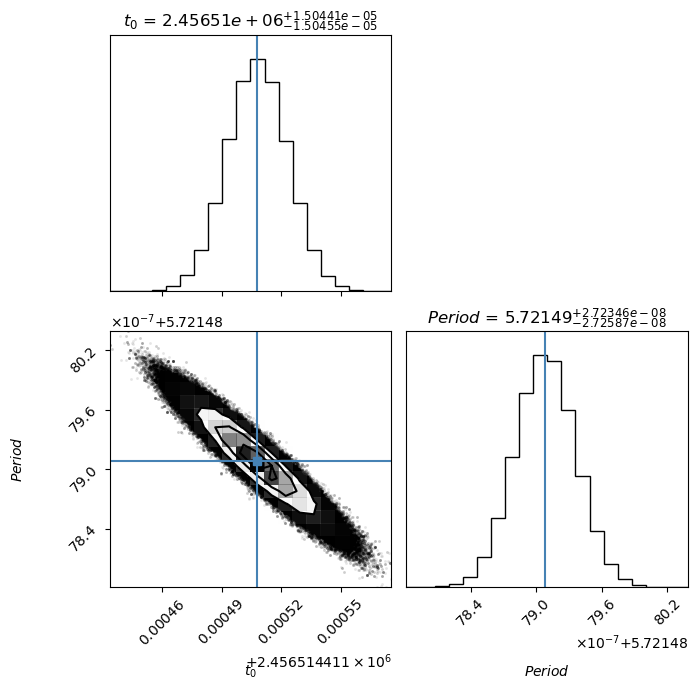

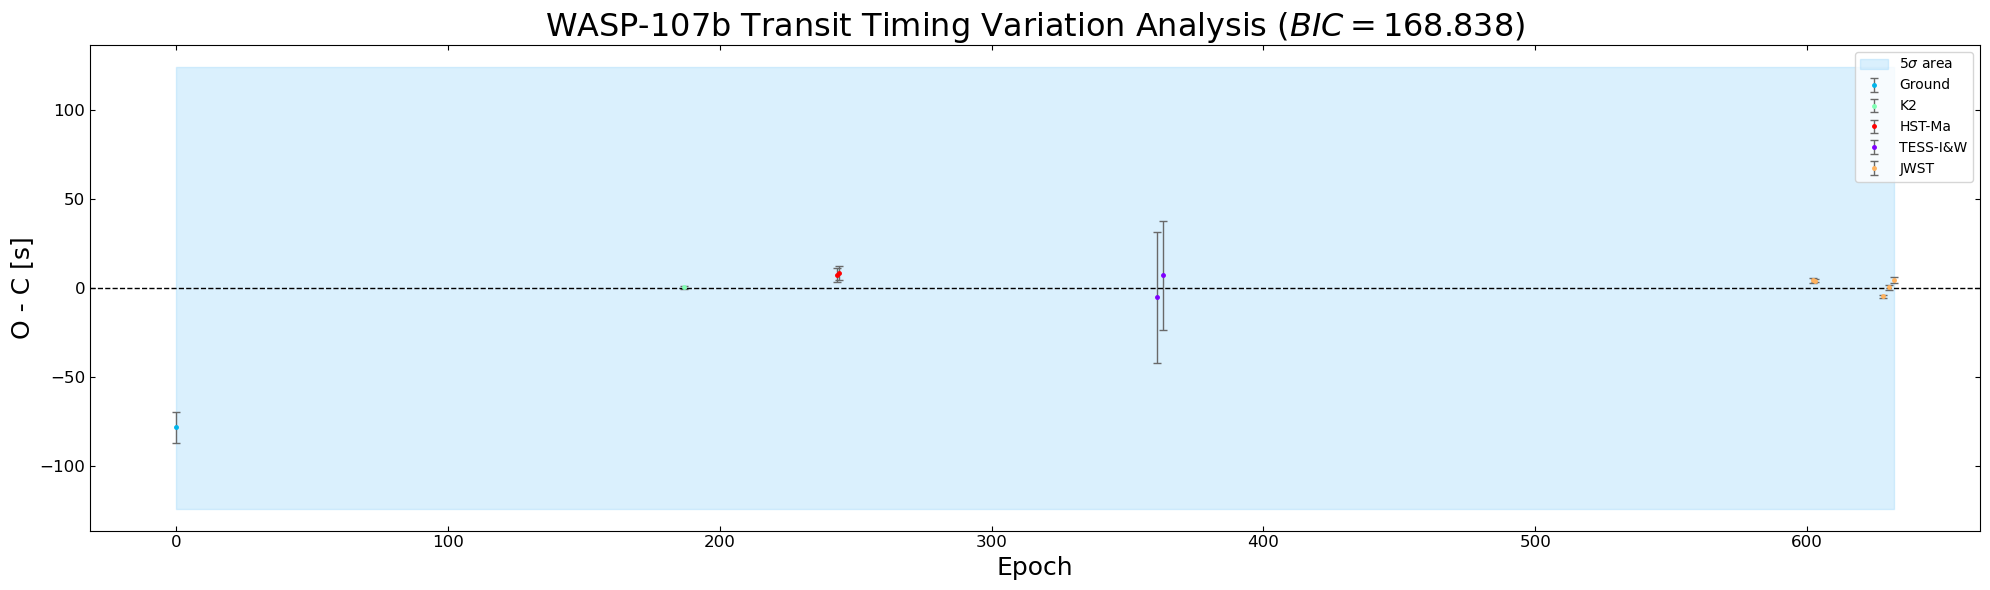

In [10]:
suffix = '_%ssigma'%rej_sigma
suffix += '_%s_%s_%s'%(sampler,kind,target)
if RE:
    suffix += '_reduced'
# suffix += ''
title = '%s Transit Timing Variation Analysis'%target
samples = TTVFIT.Fit(indir+'/results/1/',suffix,title)